# Task 4: Group Task

### Spain as country

In [139]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as cp
import cartopy.crs as ccrs
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
from rasterio.plot import show
from shapely.ops import unary_union
import rasterio
import atlite
from urllib.request import urlretrieve

In [140]:
file = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=country_shapes.geojson"
shapes = gpd.read_file(file).set_index('name')

In [141]:
spain = shapes.query("index == 'ES'").to_crs(3035).geometry
spain.explore()

In [142]:
regions = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-ESP.gpkg"
regions = gpd.read_file(regions)

In [143]:
regions

,GID_0,GID_1,COUNTRY,NAME_1,geometry
0,ESP,ESP.1_1,Spain,Andalucía,"MULTIPOLYGON (((-3.03125 35.94069, -3.03125 35..."
1,ESP,ESP.2_1,Spain,Aragón,"MULTIPOLYGON (((-0.81690 39.89858, -0.81272 39..."
2,ESP,ESP.3_1,Spain,Cantabria,"MULTIPOLYGON (((-3.93629 42.90813, -3.93672 42..."
3,ESP,ESP.4_1,Spain,Castilla-La Mancha,"MULTIPOLYGON (((-1.45231 38.58182, -1.46655 38..."
4,ESP,ESP.5_1,Spain,Castilla y León,"MULTIPOLYGON (((-5.62101 40.24145, -5.62189 40..."
5,ESP,ESP.6_1,Spain,Cataluña,"MULTIPOLYGON (((0.43801 40.54708, 0.43587 40.5..."
6,ESP,ESP.7_1,Spain,Ceuta y Melilla,"MULTIPOLYGON (((-2.44014 35.18292, -2.43958 35..."
7,ESP,ESP.8_1,Spain,Comunidad de Madrid,"MULTIPOLYGON (((-3.87292 39.90904, -3.87628 39..."
8,ESP,ESP.9_1,Spain,Comunidad Foral de Navarra,"MULTIPOLYGON (((-1.61091 41.94654, -1.61681 41..."
9,ESP,ESP.10_1,Spain,Comunidad Valenciana,"MULTIPOLYGON (((-0.75236 37.88653, -0.75236 37..."


### create 5 zones for the analysis:

In [216]:
# Andalucia
zone1 = regions.drop(range(1,17))
zone1 = unary_union(zone1.geometry)

#comunidad valencia, castilla la mancha, extremadura, madrid
zone2 = regions.drop([0,1,2,4,5,6,8,11,12,13,14,15,16,17])
zone2 = unary_union(zone2.geometry)

#cataluna und aragon
zone3 = regions.drop([0,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17])
zone3 = unary_union(zone3.geometry)

#8,14,15,4,16,2
zone4 = regions.drop([0,1,3,5,6,7,9,10,11,12,13,17])
zone4 = unary_union(zone4.geometry)

#11 Galicia
zone5 = regions.drop([0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17])
zone5 = unary_union(zone5.geometry)

geometries = [zone1,zone2,zone3,zone4,zone5]
names = ['zone_1','zone_2','zone_3','zone_4','zone_5',]


In [217]:
zones = gpd.GeoDataFrame(names, geometry = geometries)
zones['center'] = zones.geometry.centroid

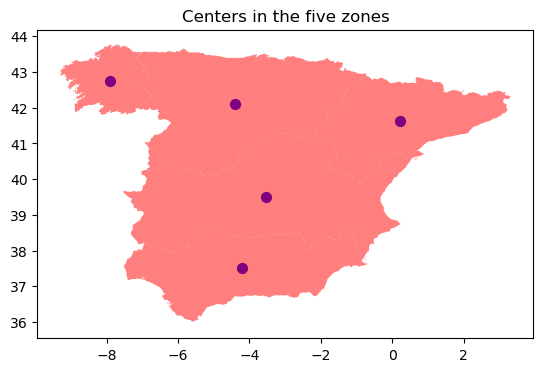

In [218]:
fig, ax = plt.subplots()

# Plot the points
zones.center.plot(ax=ax, color='blue', markersize=50)
point_color = (1, 0, 0, 0.5)
zones.geometry.plot(ax=ax, color=point_color )
ax.set_title("Centers in the five zones")

# Display the plot
plt.show()

## First, perform a land eligibility analysis
### onshore wind:
- 10km distance to airports
- 300m distance to major roads
- no natural protection areas
- maximum elevation of 2000m
- 1000m distance to built up areas
- only on suitable land cover classes

In [219]:
# file_roads = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_roads.gpkg'
# file_airport = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_airports.gpkg'
# file_classes = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fcopernicus-glc&files=PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-ES.tif'
# file_elevation = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files=GEBCO_2014_2D-ES.nc'
# file_protected = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files=WDPA_Oct2022_Public_shp-ESP.tif'
# area = spain

In [220]:
# downloading files in local filesystem
file_roads = "ne_10m_roads.gpkg"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files={file_roads}"
urlretrieve(url,file_roads)

file_airport = "ne_10m_airports.gpkg"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files={file_airport}"
urlretrieve(url,file_airport)

file_classes = "PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-ES.tif"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fcopernicus-glc&files={file_classes}"
urlretrieve(url,file_classes)

file_elevation = "GEBCO_2014_2D-ES.nc"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files={file_elevation}"
urlretrieve(url,file_elevation)

file_protected = "WDPA_Oct2022_Public_shp-ESP.tif"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files={file_protected}"
urlretrieve(url,file_protected)

# file_era5 = ""

('WDPA_Oct2022_Public_shp-ESP.tif', <http.client.HTTPMessage at 0x17c78b510>)

In [221]:
airports = gpd.read_file(file_airport)
roads = gpd.read_file(file_roads)

In [222]:
airport = airports.geometry
roads.query("continent == 'Europe'")   # with that you can reduce the data size maybe, just in case it's necessary!
road = roads.geometry

In [223]:
# function to plot the exclusions (from excercise: Preparation for Group Assignment)
def plot_area(masked, transform, shape):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = show(masked, transform=transform, cmap='Greens', vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor='k', color='None', linewidth=1)

In [259]:
# exclude road and airport
excluder_onwind = ExclusionContainer(crs=3035, res = 500)
excluder_onwind.add_geometry(road, buffer = 300)
excluder_onwind.add_geometry(airport, buffer = 10000)
# exclude natural protection area
excluder_onwind.add_raster(file_protected, crs=3035)
# exclude elevation higher than 2000m
# excluder.add_raster(file_elevation, codes = lambda x: x>2000, crs = 4326, invert=True)
# ^ this line above eliminate a lot of area, which doesnt make much sense... 
# is most of the territory of spain higher than 200??


In [260]:
masked, transform = shape_availability(regions.to_crs(3035).geometry, excluder_onwind)

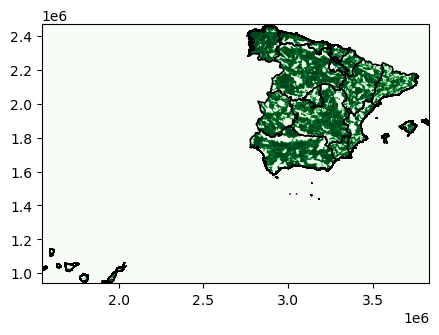

In [261]:
plot_area(masked,transform, regions.to_crs(3035).geometry)

In [227]:
# Load EEZ
EEZ = gpd.read_file("eez_v11.gpkg")

# Extract EEZ of Spain and change CRS
EEZ_Spa = EEZ[EEZ['GEONAME'] == 'Exclusive economic zone of Spain']
EEZ_Spa = EEZ_Spa.to_crs(3035)

In [228]:
#Add EEZ to regions
#how to integrate that to the regions

### Offshore Wind
- within EEZ
- up to water depth of 50m
- no natural protection areas
- 10km minimum distance to shore

In [229]:
# Land ekigibility for offshore wind
# define excluder to get eligible area
excluder_offwind = ExclusionContainer(crs=3035, res=300)

# Exclude protected areas
fn = f'WDPA_Oct2022_Public_shp-ESP.tif'
excluder_offwind.add_raster(fn, crs=3035)

#Exclude 10km  distance to shore
excluder_offwind.add_geometry(regions, buffer=10000)

# Exclude elevation < -50 m
fn = f'GEBCO_2014_2D-KE.nc' 
excluder_offwind.add_raster(fn, codes= lambda x: x<-50, crs=4326)

#to complete

### Solar (rooftop & utility)
- only on suitable land cover classes
- no natural protection areas

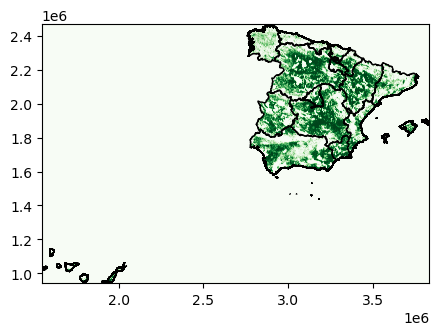

In [262]:
# Solar land eligibility

# Define excluder to get eligible area
excludersolar = ExclusionContainer(crs=3035, res=300)

# Only include suitable land classes
fn = f'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-ES.tif'
excludersolar.add_raster(fn, codes=codes_solar, crs=4326, invert=True)

# Exclude protected areas
fn = f"WDPA_Oct2022_Public_shp-ESP.tif"
excludersolar.add_raster(fn, crs=3035)

# Compute eligible area for solar
masked, transform = shape_availability(regions.to_crs(3035).geometry, excludersolar)

# Plot eligible area
plot_area(masked, transform, regions.to_crs(3035).geometry)



## Second, using atlite download historical weather data from the ERA5 dataset into an atlite. 
Cutout as shown in the lecture for a year of your choice and the geographical bounds of your selected country (add a buffer of 0.25 degrees).

<Axes: >

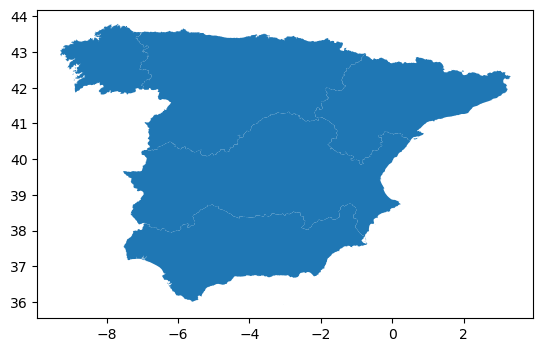

In [231]:
zones.plot()

- The following code is for creating dataset from ERA5, it doesnt have to be run anymore. 

In [232]:
# minx, miny, maxx, maxy = zones.total_bounds
# buffer = 0.25

# cutout = atlite.Cutout(
#    path = 'era5-2020-ES.nc',
#    module = 'era5',
#    x = slice(minx - buffer, maxx + buffer),
#    y = slice(miny - buffer, maxy + buffer),
#    time = "2020",
# )

# cutout.prepare()

In [233]:
cutout = atlite.Cutout('era5-2020-ES.nc')

In [234]:
cutout

<Cutout "era5-2020-ES">
 x = -9.50 ⟷ 3.50, dx = 0.25
 y = 35.75 ⟷ 44.00, dy = 0.25
 time = 2020-01-01 ⟷ 2020-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [235]:
cutout.data

<xarray.Dataset>
Dimensions:           (x: 53, y: 34, time: 8784)
Coordinates:
  * x                 (x) float64 -9.5 -9.25 -9.0 -8.75 ... 2.75 3.0 3.25 3.5
  * y                 (y) float64 35.75 36.0 36.25 36.5 ... 43.5 43.75 44.0
  * time              (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(53,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(34,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(34, 53), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 34, 53), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['height', 'influx', 'wind', 'runoff', 'temperature']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-07-12 16:45:58 GMT by grib_to_netcdf-2.25.1: /op...

<Axes: >

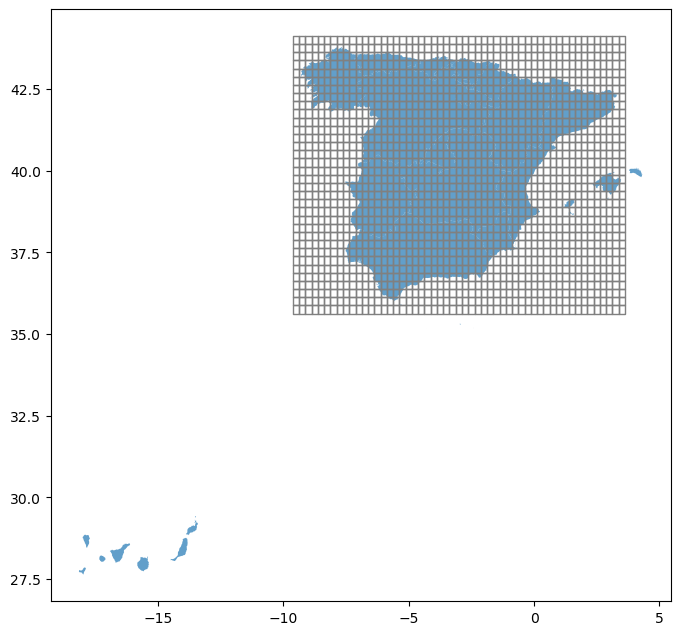

In [300]:
fig, ax = plt.subplots(figsize=(8,8))
regions.to_crs(4326).plot(ax=ax,alpha = 0.7,)
cutout.grid.plot(ax=ax, edgecolor='grey', color='None')

In [306]:

A_onsolar = cutout.availabilitymatrix(regions, excludersolar)
#A_onsun = cutout.availabilitymatrix(regions, excluder_onwind)

Compute availability matrix: 100%|██████████| 18/18 [00:16<00:00,  1.12 gridcells/s]


AttributeError: Rectangle.set() got an unexpected keyword argument 'cmap'

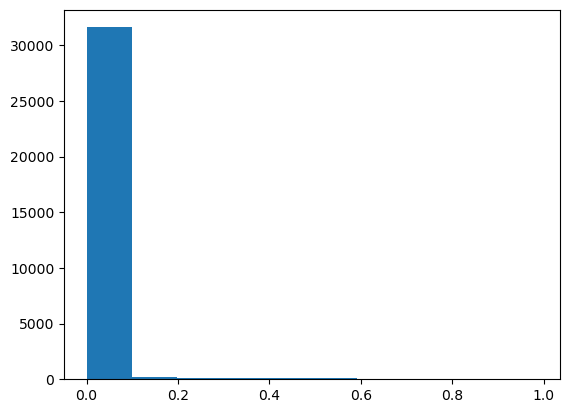

In [301]:
#it doesnt work
fig, ax = plt.subplots()
A_onsolar.sel().plot(cmap='Greens')
shape.to_crs(4326).plot(ax=ax,alpha = 0.3)
cutout.grid.plot(ax=ax, color='none', edgecolor='grey', ls=':')


In [307]:

#from isis course rasterio part  
cap_per_sqkm = 3

# Comppute area of provinces
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
# Compute onwind capacity matrix

capacity_matrix_solar = A_onsolar.stack(spatial=['y', 'x']) * area * cap_per_sqkm



In [317]:
#from the old project send in the group
# Define PV profile
pv = cutout.pv(
    panel=atlite.solarpanels.CdTe,
    matrix=capacity_matrix_solar,
    orientation='latitude_optimal',
    index=regions.index,
    per_unit=True,
)

[########################################] | 100% Completed | 2.70 s


In [319]:
#just to see the data
pv.to_pandas().head(5)

dim_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
time,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='time'>

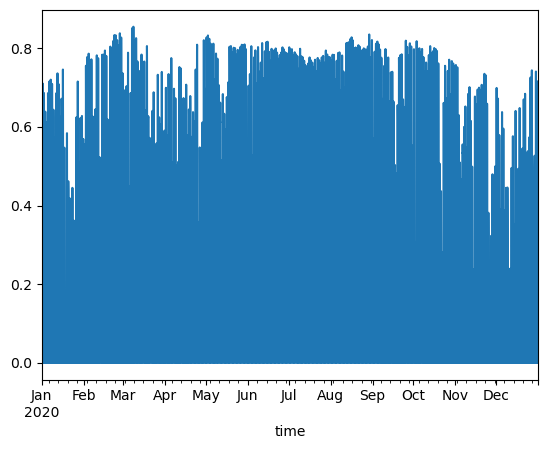

In [320]:
# just to see the data
pv.to_pandas().iloc[:,0].plot()

In [310]:
#add the potential data to the DF with coordinates 
regions['Potential Solar [MW]']=0
for i in regions.index:
    masked, transform = shape_availability(regions.loc[[i]].to_crs(3035).geometry, excludersolar)
    eligible_cells = masked.sum()
    cell_area = excludersolar.res**2/1e6
    eligible_area = abs(cell_area * eligible_cells)
    regions['Potential Solar [MW]'][i]=cap_per_sqkm*eligible_area
regions['Potential Solar [MW]']['EEZ']=0


/var/folders/n0/krsjmjn17qxbhdzx3t_s_vg40000gq/T/ipykernel_69658/137521586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regions['Potential Solar [MW]'][i]=cap_per_sqkm*eligible_area


In [305]:
regions

,GID_0,GID_1,COUNTRY,NAME_1,geometry,Potential Solar [MW]
0,ESP,ESP.1_1,Spain,Andalucía,"MULTIPOLYGON (((-3.03125 35.94069, -3.03125 35...",108947.70
1,ESP,ESP.2_1,Spain,Aragón,"MULTIPOLYGON (((-0.81690 39.89858, -0.81272 39...",73590.39
2,ESP,ESP.3_1,Spain,Cantabria,"MULTIPOLYGON (((-3.93629 42.90813, -3.93672 42...",3475.98
3,ESP,ESP.4_1,Spain,Castilla-La Mancha,"MULTIPOLYGON (((-1.45231 38.58182, -1.46655 38...",134960.58
4,ESP,ESP.5_1,Spain,Castilla y León,"MULTIPOLYGON (((-5.62101 40.24145, -5.62189 40...",148021.29
5,ESP,ESP.6_1,Spain,Cataluña,"MULTIPOLYGON (((0.43801 40.54708, 0.43587 40.5...",27922.05
6,ESP,ESP.7_1,Spain,Ceuta y Melilla,"MULTIPOLYGON (((-2.44014 35.18292, -2.43958 35...",0.00
7,ESP,ESP.8_1,Spain,Comunidad de Madrid,"MULTIPOLYGON (((-3.87292 39.90904, -3.87628 39...",11007.09
8,ESP,ESP.9_1,Spain,Comunidad Foral de Navarra,"MULTIPOLYGON (((-1.61091 41.94654, -1.61681 41...",13010.49
9,ESP,ESP.10_1,Spain,Comunidad Valenciana,"MULTIPOLYGON (((-0.75236 37.88653, -0.75236 37...",26228.88
